In [1]:
import numpy as np
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import gc
import subprocess
import json

import torch
import torch.nn as nn

import torch.optim as optim
import torch.nn.functional as F

In [2]:
torch.manual_seed(3510)
random_state = 3510
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
print(device)

cuda


In [73]:
data = pd.read_csv("train.csv")
data.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [74]:
train = data[:200000].drop("qid", axis=1)
test = data[220000:230000].drop("qid", axis=1)

In [6]:
PAD = 0
UNK = 1
BOS = 2
EOS = 3

PAD_TOKEN = '<PAD>'
UNK_TOKEN = '<UNK>'
BOS_TOKEN = '<S>'
EOS_TOKEN = '</S>'

In [7]:
word2id = {
    PAD_TOKEN: PAD,
    BOS_TOKEN: BOS,
    EOS_TOKEN: EOS,
    UNK_TOKEN: UNK,
    }

id2word = {v: k for k, v in word2id.items()}   

for s in train["question_text"]:
    for w in s.split():
        _id = len(word2id)
        word2id.setdefault(w, _id)
        id2word[_id] = w 

In [8]:
def sentence_to_ids(char2id, sentence):
    """
    単語のリストをインデックスのリストに変換する
    :param vocab: Vocabのインスタンス
    :param sentence: list of str
    :return indices: list of int
    """
    ids = [char2id.get(c, UNK) for c in sentence.split()]
    ids = [BOS] + ids + [EOS]  # </S>トークンを末尾に加える
#     ids += [EOS]  # EOSを末尾に加える
    return ids

In [9]:
train["question_text"]= [sentence_to_ids(word2id, sentence) for sentence in train["question_text"]]
test["question_text"] = [sentence_to_ids(word2id, sentence) for sentence in test["question_text"]]

In [10]:
def preprocess_seqs(seqs):
            # パディング
    max_length = max([len(s) for s in seqs])
    data = [s + [PAD] * (max_length - len(s)) for s in seqs]
     # テンソルに変換
    data_tensor = torch.tensor(data, dtype=torch.long, device=device)
    return data_tensor   

In [11]:
class DataLoader(object):
    def __init__(self, data, batch_size, shuffle=True, is_train=True):
        """
        :param src_insts: list, 入力言語の文章（単語IDのリスト）のリスト
        :param tgt_insts: list, 出力言語の文章（単語IDのリスト）のリスト
        :param batch_size: int, バッチサイズ
        :param shuffle: bool, サンプルの順番をシャッフルするか否か
        """
        self.data = data
        self.positive = data[data.target==1]
        self.negative = data[data.target==0]
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.start_index = 0
        self.is_train=is_train
        
        self.reset()
    
    def reset(self):
        if self.shuffle:
            self.negative = shuffle(self.negative, random_state=random_state)
        self.start_index = 0
    
    def __iter__(self):
        return self
    
    def __next__(self):       
        # ポインタが最後まで到達したら初期化する
        if self.start_index >= len(self.negative):
            self.reset()
            raise StopIteration()
        
        if self.is_train:
            minibatch = pd.concat([self.data[self.data.target==1].sample(self.batch_size),
                               self.data[self.data.target==0][self.start_index:self.start_index+self.batch_size]], axis=0)
        else:
            minibatch = self.data[self.start_index:self.start_index+self.batch_size]
        
        minibatch_X = preprocess_seqs(minibatch["question_text"].values)
        minibatch_y = torch.tensor(minibatch["target"].values, dtype=torch.long, device=device)
        # バッチを取得して前処理
        self.start_index += self.batch_size

        return minibatch_X, minibatch_y

In [12]:
class TextCNN(nn.Module):

    def __init__(self, vocab_size, embedding_size, class_num, kernel_num, kernel_sizes, dropout, static):
        """
        :param vocab_size: int, 入力言語の語彙数
        :param embedding_size: int, 埋め込みベクトルの次元数
        :param class_num: int, 出力のクラス数
        :param kernel_num: int,　畳み込み層の出力チャネル数
        :param kernel_sizes: list of int, カーネルのウィンドウサイズ
        :param dropout: float, ドロップアウト率
        :param static: bool, 埋め込みを固定するか否かのフラグ
        """
        super(TextCNN, self).__init__()
        
        self.static = static

        self.embedding = nn.Embedding(vocab_size, embedding_size)
        # nn.ModuleList: 任意の数のModuleをlistのような形で保持することが出来るクラス
        self.convs = nn.ModuleList(
            [nn.Conv1d(1, kernel_num, (kernel_size, embedding_size)) for kernel_size in kernel_sizes]
            )
        self.dropout = nn.Dropout(dropout)
        self.out = nn.Linear(len(kernel_sizes)*kernel_num, class_num)

    def forward(self, x):
        # x: (batch_size, max_length)
        x = self.embedding(x)  # (batch_size, max_length, embedding_size)
        
        if self.static:
            x = torch.tensor(x)  # 埋め込みを固定

        x = x.unsqueeze(1)  # (batch_size, 1, max_length, embedding_size)

        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs]  # [(batch_size, kernel_num, max_length-kernel_size+1), ...]*len(kernel_sizes)

        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  # [(batch_size, kernel_num), ...]*len(kernel_sizes)

        x = torch.cat(x, 1)  # (batch_size, len(kernel_sizes)*kernel_num)

        x = self.dropout(x)
        logit = self.out(x)  # (batch_size, class_num)
        return logit

In [56]:
model_args = {
    'vocab_size': len(id2word),
    'embedding_size': 128,
    'class_num': 2,
    'kernel_num': 64,
    'kernel_sizes': [3, 4, 5],
    'dropout': 0.5,
    'static': False,
}

lr = 0.001
num_epochs = 16
batch_size = 256
ckpt_path = 'cnn.pth'

In [57]:
# model
model = TextCNN(**model_args)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

train_dataloader = DataLoader(train, batch_size)
valid_dataloader = DataLoader(test, batch_size, is_train=False)

In [45]:
DEFAULT_ATTRIBUTES = (
    'index',
    'uuid',
    'name',
    'timestamp',
    'memory.total',
    'memory.free',
    'memory.used',
    'utilization.gpu',
    'utilization.memory'
)

def get_gpu_info(nvidia_smi_path='nvidia-smi', keys=DEFAULT_ATTRIBUTES, no_units=True):
    nu_opt = '' if not no_units else ',nounits'
    cmd = '%s --query-gpu=%s --format=csv,noheader%s' % (nvidia_smi_path, ','.join(keys), nu_opt)
    output = subprocess.check_output(cmd, shell=True)
    lines = output.decode().split('\n')
    lines = [ line.strip() for line in lines if line.strip() != '' ]

    return [ { k: v for k, v in zip(keys, line.split(', ')) } for line in lines ]

In [58]:
def compute_loss(batch_X, batch_Y, model, criterion, optimizer=None, is_train=True):
    # バッチの損失を計算
    model.train(is_train)
    pred_Y = model(batch_X)
    loss = criterion(pred_Y, batch_Y.view(-1))
    
    if is_train:  # 訓練時はパラメータを更新
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return loss.item()

In [59]:
log_train_loss=[]
log_valid_loss=[]
# 訓練
for epoch in range(1, num_epochs+1):
    #print("first -> memory.used", get_gpu_info()[0]['memory.used'])
    train_loss = 0.
    valid_loss=0.
    # train
    for i, data in enumerate(train_dataloader):
        batch_X, batch_Y = data
        loss = compute_loss(
            batch_X, batch_Y, model, criterion, optimizer, is_train=True
            )     
        
        train_loss += loss
        #print("batch",i,"-> memory.used", get_gpu_info()[0]['memory.used'])
        
    
    train_loss = train_loss/len(train)
    #print("train_end -> memory.used", get_gpu_info()[0]['memory.used'])
    
    for i, data in enumerate(valid_dataloader):
        batch_X, batch_Y = data
        loss = compute_loss(
            batch_X, batch_Y, model, criterion, optimizer, is_train=False
            )             
        valid_loss += loss
        #print("batch",i,"-> memory.used", get_gpu_info()[0]['memory.used'])
    
    valid_loss = valid_loss/len(test)
        
    #print("valid_end -> memory.used", get_gpu_info()[0]['memory.used'])
    
    print("train:",train_loss, ", valid:", valid_loss)
    log_train_loss.append(train_loss)
    log_valid_loss.append(valid_loss)    

train: 0.001411647888123989 , valid: 0.0010764951780438423
train: 0.0006607065016776323 , valid: 0.0007527477025985718
train: 0.0003531021471321583 , valid: 0.0008327482655644417
train: 0.00020912730576470496 , valid: 0.0009710137382149697
train: 0.0001332700364664197 , valid: 0.001135358192026615
train: 8.951031319331377e-05 , valid: 0.0013156113624572753
train: 6.18623003223911e-05 , valid: 0.0015288485988974572
train: 4.6249739360064265e-05 , valid: 0.0016838643550872803
train: 3.802671341923997e-05 , valid: 0.0018389321237802505
train: 2.990433629369363e-05 , valid: 0.0020429480656981467
train: 2.4480146672576665e-05 , valid: 0.002196960198879242
train: 2.4531675543403253e-05 , valid: 0.002446245750784874


KeyboardInterrupt: 

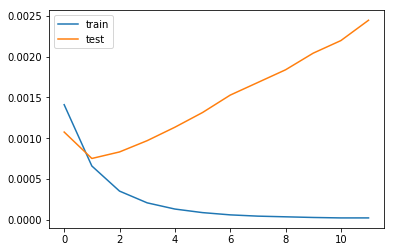

In [60]:
plt.plot(log_train_loss, label="train")
plt.plot(log_valid_loss, label="test")
plt.legend()
plt.savefig('cnn.png')

In [68]:
class DataLoader_Normal(object):
    def __init__(self, data, batch_size, shuffle=True, is_train=True):
        """
        :param src_insts: list, 入力言語の文章（単語IDのリスト）のリスト
        :param tgt_insts: list, 出力言語の文章（単語IDのリスト）のリスト
        :param batch_size: int, バッチサイズ
        :param shuffle: bool, サンプルの順番をシャッフルするか否か
        """
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.start_index = 0
        self.is_train=is_train
        
        self.reset()
    
    def reset(self):
        if self.shuffle:
            self.data = shuffle(self.data, random_state=random_state)
        self.start_index = 0
    
    def __iter__(self):
        return self
    
    def __next__(self):       
        # ポインタが最後まで到達したら初期化する
        if self.start_index >= len(self.data):
            self.reset()
            raise StopIteration()
        
        minibatch = self.data[self.start_index:self.start_index+self.batch_size]
        minibatch_X = preprocess_seqs(minibatch["question_text"].values)
        minibatch_y = torch.tensor(minibatch["target"].values, dtype=torch.long, device=device)
        # バッチを取得して前処理
        self.start_index += self.batch_size

        return minibatch_X, minibatch_y

In [69]:
# model
model_n = TextCNN(**model_args)
model_n = model_n.to(device)

optimizer_n = optim.Adam(model_n.parameters(), lr=lr)
criterion_n = nn.CrossEntropyLoss()

train_dataloader = DataLoader_Normal(train, batch_size)
valid_dataloader = DataLoader_Normal(test, batch_size, is_train=False)

In [70]:
log_train_loss=[]
log_valid_loss=[]
# 訓練
for epoch in range(1, num_epochs+1):
    #print("first -> memory.used", get_gpu_info()[0]['memory.used'])
    train_loss = 0.
    valid_loss=0.
    # train
    for i, data in enumerate(train_dataloader):
        batch_X, batch_Y = data
        loss = compute_loss(
            batch_X, batch_Y, model_n, criterion_n, optimizer_n, is_train=True
            )     
        
        train_loss += loss
        #print("batch",i,"-> memory.used", get_gpu_info()[0]['memory.used'])
        
    
    train_loss = train_loss/len(train)
    #print("train_end -> memory.used", get_gpu_info()[0]['memory.used'])
    
    for i, data in enumerate(valid_dataloader):
        batch_X, batch_Y = data
        loss = compute_loss(
            batch_X, batch_Y, model_n, criterion_n, optimizer_n, is_train=False
            )             
        valid_loss += loss
        #print("batch",i,"-> memory.used", get_gpu_info()[0]['memory.used'])
    
    valid_loss = valid_loss/len(test)
        
    #print("valid_end -> memory.used", get_gpu_info()[0]['memory.used'])
    
    print("train:",train_loss, ", valid:", valid_loss)
    log_train_loss.append(train_loss)
    log_valid_loss.append(valid_loss)    

train: 0.0007505746500194073 , valid: 0.0006767131686210632
train: 0.0006064429639652372 , valid: 0.0006084707066416741
train: 0.0005072246394306421 , valid: 0.0006103263720870018
train: 0.00042416536886245013 , valid: 0.0006045921608805656
train: 0.0003403429441899061 , valid: 0.0006565892942249775
train: 0.0002716307493671775 , valid: 0.0007057852981612086
train: 0.00020886497647501528 , valid: 0.0008297539591789246
train: 0.0001609054811950773 , valid: 0.0009243253074586391
train: 0.00012590172235388308 , valid: 0.0011109501525759697
train: 0.00010038565666647628 , valid: 0.0011708020456135274
train: 7.639833238674327e-05 , valid: 0.0012836005493998528
train: 6.45869873126503e-05 , valid: 0.0015469376429915428
train: 5.216552328784019e-05 , valid: 0.0015428642764687538


KeyboardInterrupt: 

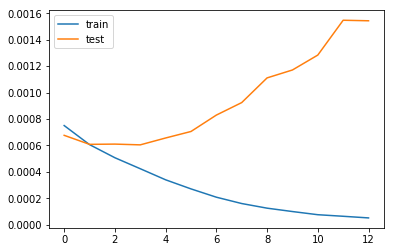

In [71]:
plt.plot(log_train_loss, label="train")
plt.plot(log_valid_loss, label="test")
plt.legend()
plt.savefig('cnn.png')